In [1]:
from regimetry.utils.path_utils import get_project_root
from regimetry.config import Config
from regimetry.services.data_transformation_service import DataTransformationService
from regimetry.logger_manager import LoggerManager
from regimetry.models.rolling_windows_generator import RollingWindowGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from regimetry.models.positional_encoding import PositionalEncoding
import matplotlib.pyplot as plt

In [2]:


logging = LoggerManager.get_logger("positional_encoding.ipynb")

In [3]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed


In [4]:
data_transformation_service = DataTransformationService()
train_arr, preprocessor_obj = (
    data_transformation_service.initiate_data_transformation()
)

[ 2025-05-12 08:36:40 ] INFO [../../src/regimetry/services/data_transformation_service.py:134] - 📁 Loaded full dataset for transformation.
[ 2025-05-12 08:36:40 ] INFO [../../src/regimetry/services/data_transformation_service.py:60] - Including columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions', 'Confidence', 'ATR', 'AHMA', 'Leavitt_Projection', 'Leavitt_Convolution', 'LC_Slope', 'LC_Intercept', 'LC_Acceleration', 'Convolution_Probability', 'Baseline_Bullish', 'Baseline_Bearish', 'Baseline_Valid', 'ML_Trade_Direction', 'ML_Signal_Quality', 'ML_Confirmed', 'LC_Acceleration_Shift', 'LC_Slope_Shift', 'LC_Acceleration_STD', 'LC_Slope_STD', 'Threshold', 'Confirm_Threshold', 'Trend', 'Trend_Within_Threshold', 'Confirmed_Trend', 'Confirmed_Trend_Within_Threshold', 'Stop_Loss_Price', 'Take_Profit_1_Price', 'Take_Profit_2_Price', 'SL_Pips', 'TP1_Pips', 'TP2_Pips', 'SL_Ticks', 'TP1_Ticks', 'TP2_Ticks', 'News_Conflict', 'Prevailing_Trend', 'Baseline_Aligned', 'Trend_Agreement', 'LC

In [5]:
logging.info("🧊 Generating rolling windows.")
if hasattr(train_arr, "toarray"):  # Handle sparse matrix if returned
    train_arr = train_arr.toarray()
window_gen = RollingWindowGenerator(
    data=train_arr,
    window_size=30
)
rolling_windows = window_gen.generate()
logging.info(f"✅ Rolling windows generated: shape={rolling_windows.shape}")


[ 2025-05-12 08:36:40 ] INFO [../../../../../../../../../var/folders/4q/cv174s2d24n6j71rjjzfsk6w0000gn/T/ipykernel_24389/2023955594.py:1] - 🧊 Generating rolling windows.
[ 2025-05-12 08:36:40 ] INFO [../../../../../../../../../var/folders/4q/cv174s2d24n6j71rjjzfsk6w0000gn/T/ipykernel_24389/2023955594.py:9] - ✅ Rolling windows generated: shape=(1840, 30, 80)


## ✅ 1. Assume your inputs:

In [6]:
X = tf.convert_to_tensor(rolling_windows, dtype=tf.float32)
print(f"X shape: {X.shape}")
X_pe = PositionalEncoding.add(X, method='sinusoidal')
print(f"X_pe shape: {X_pe.shape}")


X shape: (1840, 30, 80)
X_pe shape: (1840, 30, 80)


In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.0):
    # Multi-Head Self-Attention block
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual

    # Feed-forward network via 1x1 Conv
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual again

def build_unsupervised_transformer_encoder(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout=0.1,
):
    """
    Build a transformer encoder model for unsupervised feature extraction.

    Args:
        input_shape (tuple): Shape of input tensor (seq_len, d_model)
        head_size (int): Dimension of each attention head
        num_heads (int): Number of attention heads
        ff_dim (int): Hidden size of feed-forward network
        num_transformer_blocks (int): Number of stacked encoder layers
        dropout (float): Dropout rate

    Returns:
        keras.Model: Unsupervised transformer model that outputs a pooled embedding
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Pool over time dimension to get a fixed-size embedding
    x = layers.GlobalAveragePooling1D()(x)
    return keras.Model(inputs=inputs, outputs=x, name="UnsupervisedTransformerEncoder")

## ✅ 2. Build the model

In [8]:
model = build_unsupervised_transformer_encoder(
    input_shape=X_pe.shape[1:],  # (30, 1274)
    head_size=256,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout=0.1,
)
model.summary()

Model: "UnsupervisedTransformerEncoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 80)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 80)    │    330,832 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 80)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 80)    │        160 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 80)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │     10,368 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 80)    │     10,320 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 80)    │        160 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 80)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 80)    │    330,832 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 80)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 80)    │        160 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 80)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 128)   │     10,368 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 80)    │     10,320 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 80)    │        160 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 80)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 703,680 (2.68 MB)

 Trainable params: 703,680 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

## ✅ 3. Extract embeddings

In [9]:
embeddings = model.predict(X_pe, batch_size=64)  # Output: (1167, 1274)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [10]:
embeddings.shape

(1840, 80)

/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


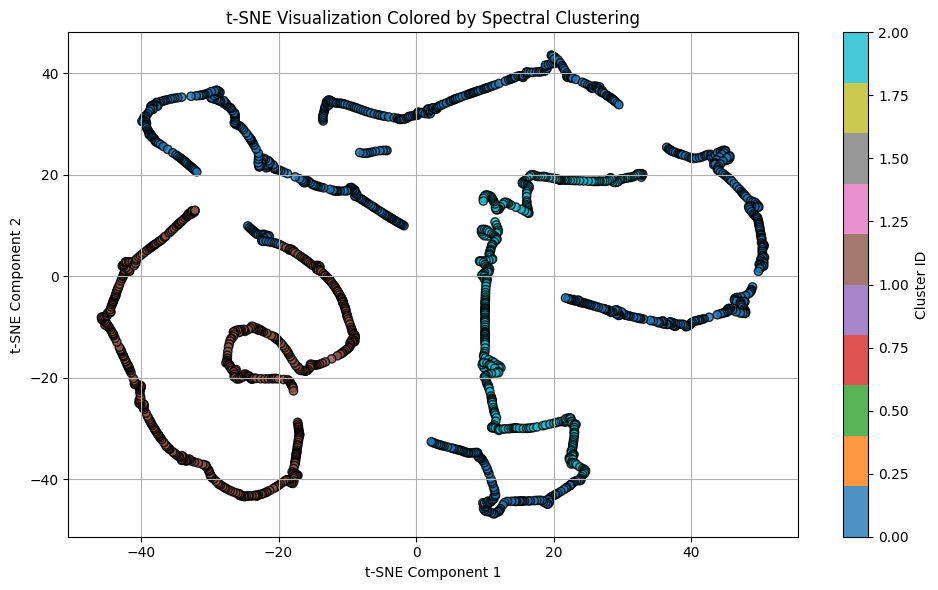

Cluster Summary: {np.int32(0): np.int64(896), np.int32(1): np.int64(567), np.int32(2): np.int64(377)}


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

# Step 1: Run model to get embeddings
# embeddings = model.predict(X_pe, batch_size=64)

# Step 2: Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# ✅ Step 3: Spectral Clustering on real embedding space (not t-SNE)
n_clusters = 3
spectral = SpectralClustering(
    n_clusters=n_clusters,
    #affinity='rbf',  # or 'nearest_neighbors'
    affinity='nearest_neighbors',
    assign_labels='kmeans',
    random_state=42,
)
cluster_labels = spectral.fit_predict(embeddings_scaled)

# ✅ Step 4: t-SNE for visualization only
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# ✅ Step 5: Use cluster_labels from SpectralClustering for coloring
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter( 
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=cluster_labels,
    cmap='tab10',
    edgecolors='k',
    alpha=0.8
)
#scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=np.arange(len(embeddings_tsne)), cmap='viridis')

plt.title("t-SNE Visualization Colored by Spectral Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Cluster ID")
#plt.colorbar(scatter, label="sequence index")

plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print cluster summary
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster Summary:", cluster_summary)


/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


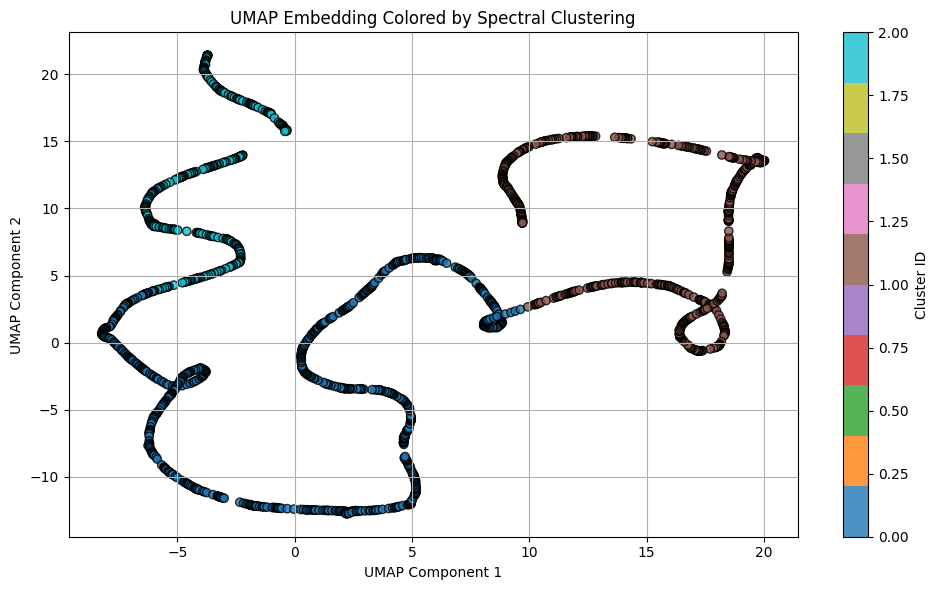

In [12]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
embeddings_umap = umap.fit_transform(embeddings_scaled)

# Plot with cluster_labels from SpectralClustering
plt.figure(figsize=(10, 6))
plt.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='tab10',
    edgecolors='k',
    alpha=0.8
)
plt.title("UMAP Embedding Colored by Spectral Clustering")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()